In [1]:
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import datetime 
import time 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb
import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
from pandas import read_hdf
df_final_train=read_hdf('data/fea_sample/storage_sample_stage4.h5','train_df',mode='r')
df_final_test=read_hdf('data/fea_sample/storage_sample_stage4.h5','test_df',mode='r') 

In [3]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [4]:
y_train=df_final_train.indicator_link
y_test=df_final_test.indicator_link

In [5]:
df_final_train.drop(['source_node', 'destination_node', 'indicator_link'],axis=1, inplace=True)
df_final_test.drop(['source_node', 'destination_node', 'indicator_link'],axis=1, inplace=True)


In [6]:
df_final_train.head(2)
df_final_test.head(2)

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,0,0.0,0.029161,0.0,14,6,9,1,0,0.0,...,5.904807e-11,2.701538e-12,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12
1,0,0.0,0.000000,0.0,17,1,19,0,0,0.0,...,2.545382e-10,2.248568e-14,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14


In [7]:
df_final_test.head(2)

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,0,0.0,0.029161,0.0,14,6,9,1,0,0.0,...,5.904807e-11,2.701538e-12,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12
1,0,0.0,0.000000,0.0,17,1,19,0,0,0.0,...,2.545382e-10,2.248568e-14,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14


<h3>Training RandomForestClassifier</h3>

Estimator:  10 , Train Score:  0.9063252121775113 , Test Score:  0.8745605278006858
Estimator:  50 , Train Score:  0.9205725512208812 , Test Score:  0.9125653355634538
Estimator:  100 , Train Score:  0.9238690848446947 , Test Score:  0.9141199714153599
Estimator:  250 , Train Score:  0.9239789348046863 , Test Score:  0.9188007232664732
Estimator:  450 , Train Score:  0.9237190618658074 , Test Score:  0.9161507685828595


Text(0.5, 1.0, 'Estimator vs Score at depth of 5 ')

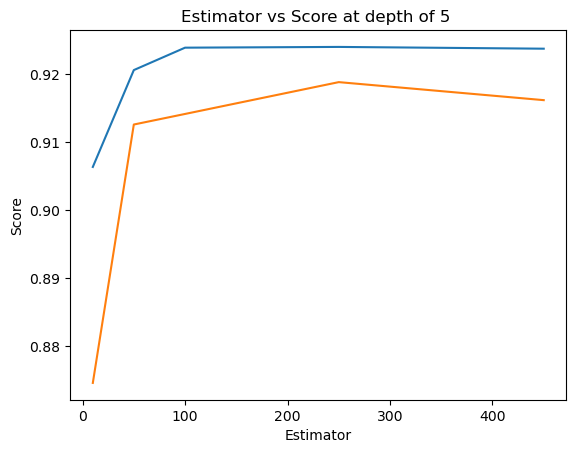

In [12]:
estimators=[10,50,100,250,450]
train_scores=[]
test_scores=[]
for i in estimators:
    clf=RandomForestClassifier(
        bootstrap=True,
        class_weight=None,
        criterion='gini',
        max_depth=5,
        max_features='auto',
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,  
        min_samples_leaf=52,
        min_samples_split=120,
        min_weight_fraction_leaf=0.0,
        n_estimators=i,
        n_jobs=-1,
        random_state=25,
        verbose=0,
        warm_start=False
    )
    clf.fit(df_final_train,y_train)
    train_sc=f1_score(y_train, clf.predict(df_final_train))
    test_sc=f1_score(y_test, clf.predict(df_final_test))
    train_scores.append(train_sc)
    test_scores.append(test_sc)
    print("Estimator: ",i,", Train Score: ",train_sc, ", Test Score: ",test_sc)
plt.plot(estimators, train_scores,label='Train Score')  
plt.plot(estimators, test_scores,label='Test Score')
plt.xlabel("Estimator")
plt.ylabel("Score")
plt.title("Estimator vs Score at depth of 5 ")

<b>Training Model with Different Depths</b>

Depth:  3 , Train Score:  0.8916120853581238 , Test Score:  0.8687934859875491
Depth:  9 , Train Score:  0.9572226298198419 , Test Score:  0.9222953031452904
Depth:  11 , Train Score:  0.9623451340902863 , Test Score:  0.9252318758281279
Depth:  15 , Train Score:  0.9634267621927706 , Test Score:  0.9231288356496615
Depth:  20 , Train Score:  0.9631629153051491 , Test Score:  0.9235051024711141
Depth:  35 , Train Score:  0.9634333127085721 , Test Score:  0.9235601652753184
Depth:  50 , Train Score:  0.9634333127085721 , Test Score:  0.9235601652753184
Depth:  70 , Train Score:  0.9634333127085721 , Test Score:  0.9235601652753184
Depth:  130 , Train Score:  0.9634333127085721 , Test Score:  0.9235601652753184


Text(0.5, 1.0, 'Depth vs Score with 115 Estimators')

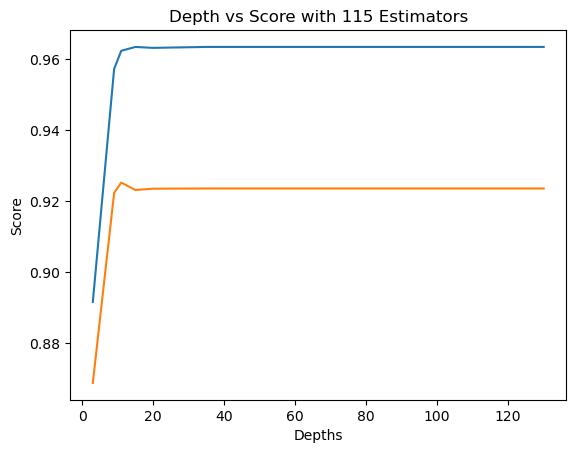

In [13]:
depths=[3,9,11,15,20,35,50,70,130]
train_scores=[]
test_scores=[]
for i in depths:
    clf=RandomForestClassifier(
        bootstrap=True,
        class_weight=None,
        criterion='gini',
        max_depth=i,
        max_features='auto',
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,  
        min_samples_leaf=52,
        min_samples_split=120,
        min_weight_fraction_leaf=0.0,
        n_estimators=115,
        n_jobs=-1,
        random_state=25,
        verbose=0,
        warm_start=False
    )
    clf.fit(df_final_train,y_train)
    train_sc=f1_score(y_train, clf.predict(df_final_train))
    test_sc=f1_score(y_test, clf.predict(df_final_test))
    train_scores.append(train_sc)
    test_scores.append(test_sc)
    print("Depth: ",i,", Train Score: ",train_sc, ", Test Score: ",test_sc)
plt.plot(depths, train_scores,label='Train Score')  
plt.plot(depths, test_scores,label='Test Score')
plt.xlabel("Depths")
plt.ylabel("Score")
plt.title("Depth vs Score with 115 Estimators")

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

In [16]:
param_dist={"n_estimators":sp_randint(105,125),"max_depth":sp_randint(10,15),"min_samples_split":sp_randint(110,190),"min_samples_leaf":sp_randint(25,65)}
clf=RandomForestClassifier(random_state=25,n_jobs=-1)
rf_random=RandomizedSearchCV(clf,param_distributions=param_dist,n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True)
rf_random.fit(df_final_train, y_train)
print("Mean Train Score:", rf_random.cv_results_['mean_train_score'])
print("Mean Test Score:", rf_random.cv_results_['mean_test_score'])


Mean Train Score: [0.96294922 0.96266735 0.96115674 0.96263457 0.96430539]
Mean Test Score: [0.96225042 0.96215492 0.9605708  0.96194014 0.96330005]


In [17]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [18]:
#Best estimator with depth=14, and estimator=121
clf=RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)
clf.fit(df_final_train, y_train)

y_train_pred=clf.predict(df_final_train)
y_test_pred=clf.predict(df_final_test)

print("Train f1 socre: ",f1_score(y_train,y_train_pred))
print("Test f1 socre: ",f1_score(y_test,y_test_pred))




Train f1 socre:  0.9652533106548414
Test f1 socre:  0.9241678239279553


In [19]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C=confusion_matrix(test_y, predict_y)
    A=(((C.T)/(C.sum(axis=1))).T)
    B=(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    labels=[0,1]
    cmap=sns.light_palette("blue")
    plt.subplot(1,3,1)
    sns.heatmap(C,annot=True, cmap=cmap, fmt='.3f',xticklabels=labels,yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.title("Confusion Matrix")
    plt.subplot(1,3,2)
    sns.heatmap(B,annot=True, cmap=cmap, fmt='.3f',xticklabels=labels,yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.title("Precision Matrix")
    plt.subplot(1,3,3)
    sns.heatmap(A,annot=True, cmap=cmap, fmt='.3f',xticklabels=labels,yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.title("Recall Matrix")
    plt.show()
    

Train Confusion Matrix


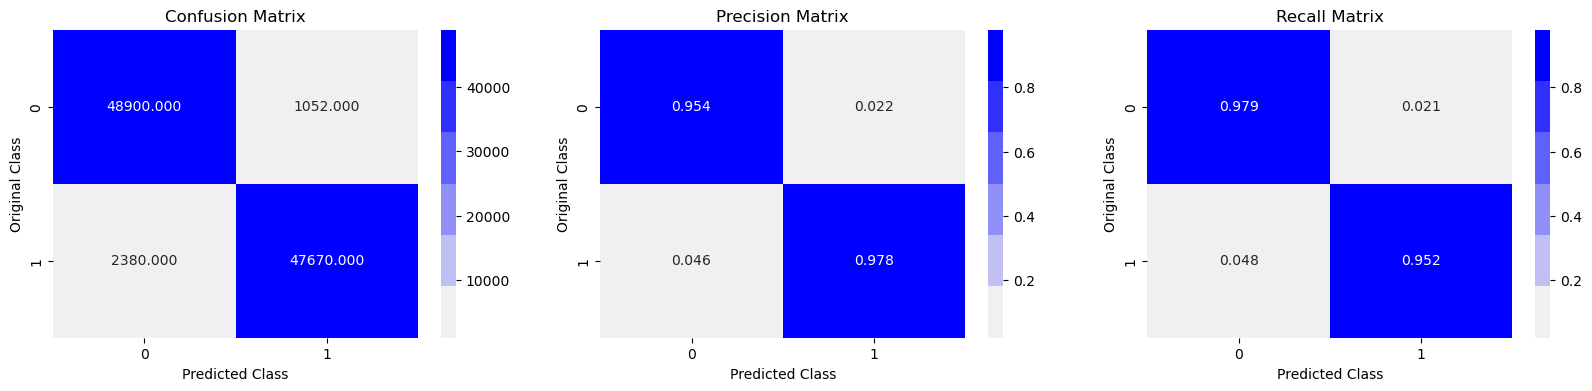

Test Confusion Matrix


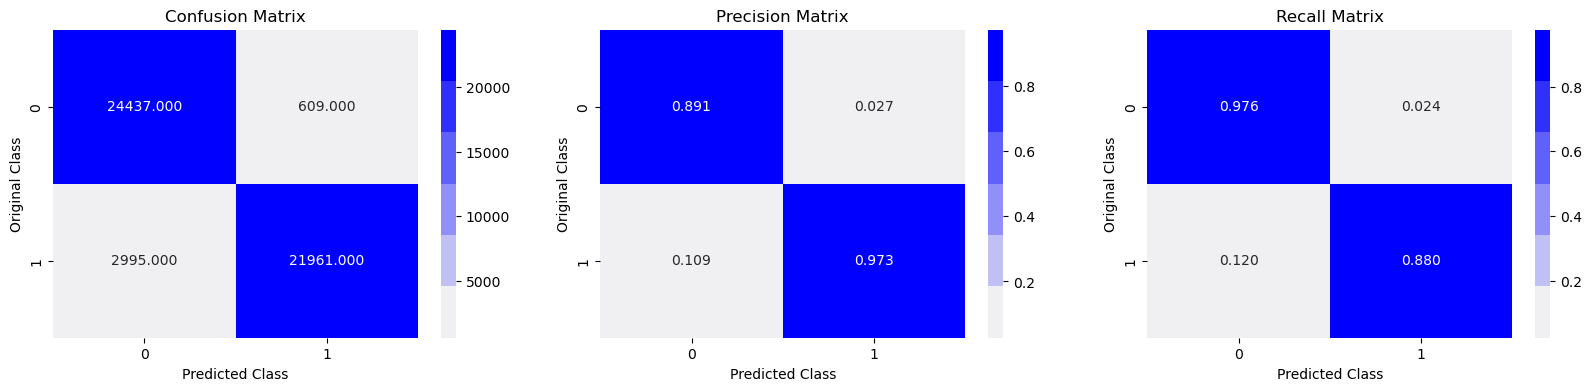

In [20]:
print("Train Confusion Matrix")
plot_confusion_matrix(y_train, y_train_pred)
print("Test Confusion Matrix")
plot_confusion_matrix(y_test, y_test_pred)


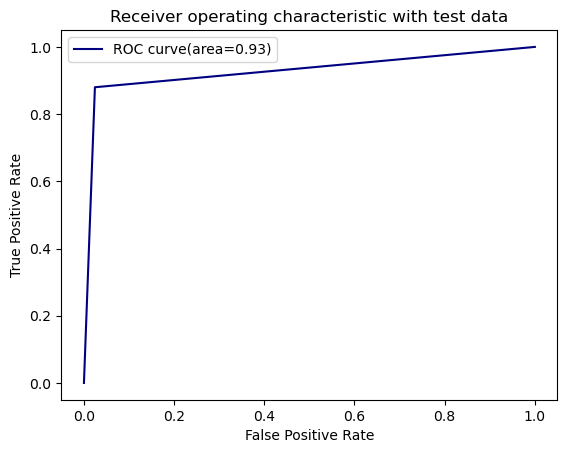

In [21]:
#Ploting ROC_curve and AUC
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths=roc_curve(y_test, y_test_pred)
auc_sc=auc(fpr,tpr)
plt.plot(fpr,tpr,color='navy', label='ROC curve(area=%0.2f)'%auc_sc)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic with test data")
plt.legend()
plt.show()

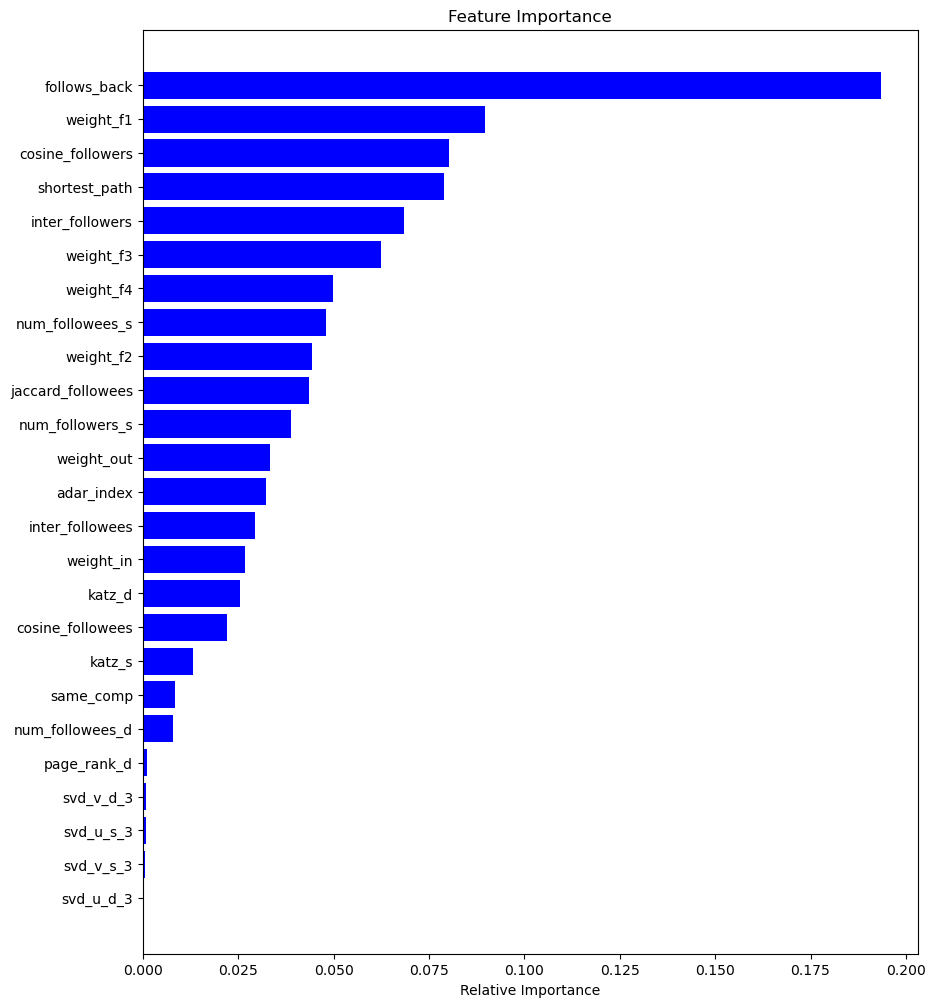

In [23]:
#Feature importance
features=df_final_train.columns
importances=clf.feature_importances_
indicies=(np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title("Feature Importance")
plt.barh(range(len(indicies)),importances[indicies],color='b', align='center')
plt.yticks(range(len(indicies)),[features[i] for i in indicies])
plt.xlabel("Relative Importance")
plt.show()